# Alex Gilbert Machine Learning Homework 1

Introduction:

This document contains an implementation of the PLA algorithm as outlined in ‘Machine Learning’ lectures. The document consists of four sections: introduction, functions, results, and an appendix with testing evidence. This is the introduction section describing the aims of the project and what was conducted. The functions section consists of all the functions built for this project to solve the problems set, more information about each function and what it performs can be found within the comments in the code of each function. The results section outlines the problems which were set, how the functions were used to solve the problems, and any output requested by the problems. Testing was continuous during building of the functions however a problem with a known solution was tested and results captured and compared in the testing appendix. The ‘known’ results are in the form of an excel document which will be attached. 

General observations:
It appears the algorithm’s convergence relies heavily upon the initial random weights. For example, thinking in 2 dimensions, the inclusion of weight zero requires the addition of a dimension to the 2 dimensional data points consisting entirely of 1 for each data point. This effectively ‘lifts’ the data from the z = 0 plane in 3 dimensions to the z = 1 plane. If the initial random initialisation of weights causes weight zero to point hugely in the ‘wrong’ direction (the true weight zero should be positive however the initial guess in large and negative) since each update to the weights can only increase/decrease weight zero by 1 it can take a long time for the weights to reach values which will separate the date. There are a number of ways this can be corrected, by multiplying the data point vector by a scalar before adding it to the weight vector in the update of the weight vector. Alternately some approaches I found online use the zero vector as an initial vector, in my case I normalised the size of the initial weight vector by the mean length of data point vectors. The idea being that this approach will be adaptable to all situations: if the data vectors are large it will be large, and if the data vectors are small it will be small. I have not carried out testing of the best choice for the initial weights as this is out of scope of this work. 

Finding an equation of a hyperplane separating data in a random fashion is itself not a trivial problem to solve, a simple approach would be to choose the mean data point then choose random weights for each dimension and calculate a weight zero to ensure the equation of the separating hyperplane passes through the mean point. This however is not a random selection as the mean data point will always lie on the boundary. Another was which is what I used initially was to randomly select a data point within the convex hull produced by the data points and use this rather than the mean data point to produce the separating plane. This was successful in lower dimensions however the construction of a convex hull is highly time consuming in higher dimensions. The final approach I took was to pick a random weight for each dimension except zero, select a point randomly within the min max bounds of the data in each dimension (except ((the additional 'zero' dimension), assume a plane through that data point would separate the data, calculate weight zero to ensure the hyperplane would go through the chosen data point, then evaluate the data points and check there was at least one data point above zero and one below, if not select a new point an repeat until one was found. Note this approach is likely not optimal however optimally finding data points inside a convex hull is out of scope of this project.

In the code it would be more efficient to store the data in a numpy array rather than a pandas dataframe as the calculations are much faster as numpy arrays and I twice convert the dataframe to a numpy array. This will be time and memory expensive however from my past experience in general data is best stored in a dataframe as it provides much additional functionality above that of numpy arrays. It transpired however after building the code that in the problem we are using linear algebra almost entirely to solve the problem meaning numpy arrays are the more natural data structure to use. Since there is no requirement to produce optimal code I have left the code in its original form so as to avoid laborious refactoring.

There is no type checking on the input of functions, this is because this code is not designed to be used by non-technical users. The conversion of jupyter notebook directly to PDF cased rendering issues in latex, to solve these problems this PDF has been built using the PDF printer native to Windows, there are still some rendering issues however fewer than the latex approach. 

Code designed and written by Alex G


# Functions

In [81]:
#import required libraries
print("Importing dependencies...")
import pandas as pd
import random 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import time
import math as maths

print("Dependency import complete.")


Importing dependencies...
Dependency import complete.


In [82]:
def CreateRandomData(nDataPoints, nDimensions, bounds = None, seed = None, debug = False):
    # this function creates random data points to test the Perceptron Learning Algorithm
    # 
    # inputs: 
    # nDataPoints - int, the number of data points needed
    # nDimensions - int, the number of dimension needed for the data
    # bounds - list of tuplues - this is the bounds for each dimension of the data
    # seed - int or none, random seed to allow for repetition of randomisation or none then no seed
    # debug - bool, used to print out information when testing
    
    # outputs:
    # outputDF - nDataPoints x nDimensions dataframe, this is a data frame containing the data 
    # meanMagnitudeOfData - float, the mean magnitude of the data vectors, this is used for normalisation
    
    # assumptions:
    # all inputs are of the type we expect
    # the 'bounds' input tuples are in order
    # nDimensions = len(bounds)
    
    # Note:
    # by using bounds as in this function the points can only everlie within an n-dimensional
    # rectangle - probably sufficient for this task
    
    #used to seed random numbers if reproducabilty is required for testing 
    np.random.seed(seed)

    #####################################################
    ############ create DF with random data #############
    #####################################################
    
    # create columns names (dim_0 will be a column of 1s)
    colNames = ['dim_%s' % str(i) for i in range(nDimensions+1)]
    
    #empty list to fill with data
    tempDataNP = []
    
    #if not given any specific bounds use the below as defaults in every dimension
    if bounds is None:
        bounds = [(-10,10) for index in range(nDimensions)]
    
    #create random data for each dimension
    for thisBound in bounds:
        tempDataNP.append(np.random.uniform(thisBound[0],thisBound[1],nDataPoints))
    
    # stack random dinension data to produce single NP array with all data
    dataNp = np.stack(tempDataNP,1)
    
    # create np array one 1s for dim_0
    onesNp = np.array([[1] for index in range(nDataPoints)])
    
    # concat the array of 1s to the rest of the data
    dataNp = np.concatenate((onesNp,dataNp), axis = 1)
    
    # create data frame from numpy array
    outputDF = pd.DataFrame(dataNp, columns = colNames)
    
    # mean length of data vectors, used to improve random weights initial guess
    meanMagnitudeOfData = np.sqrt(np.square(outputDF)).sum(axis=1).mean()
    
    if debug:
        print("CreateRandomData DONE")
    
    return outputDF, meanMagnitudeOfData

In [83]:
def CreateRandomWeights(nWeights, bounds = (-100, 100), seed = None, debug = False):
    
    # This function creates random coefficients for the separating plane, the reason this is in a stand-alone
    # function is that it turns out to be none-trivial and is used to both create the separating hyperplane
    # and for the initial guess for the weights in the PLA
    
    # inputs:
    # nWeights - int, number of weights needed 
    # bounds - tuple of two numbers, sensible bounds for the coefficients, (see notes below)
    # seed - int or none, random seed to allow for repetition of randomisation or none then no seed
        # debug - bool, used to print out information when testing
    
    # outputs:
    # weights - np array size nWeights x 1, the weights for the separating plane
    
    # assumptions:
    
    # notes:
    # since the coefficients of the input variables can be effectively any number within (-inf, inf) it's 
    # probably sensible to set some limits on the size when creating out initial random 'guesses'
    # it's also probably sensible to enforce the rule that at least one coefficient has to be non zero
    # as the zero vector would guarantee everything maps to 0, since we want to map data points to +/-1 
    # this would mean every data point being incorrectly assigned
    #
    # the reason for including 'meanVectorMagnitude' as an input to this function is that from testing
    # with completely random weights it turned out that if there is a significant magnitude difference between the 
    # data point vectors and the weights vector the addition/subtraction was biassed towards the extremely large
    # vector, evening up the size of the vectors improved the convegence of the algorithm
    #
    
    #used to seed random numbers if reproducabilty is required for testing 
    np.random.seed(seed)
    
    #used to avoind infinite loop
    whileCount = 0
    
    nonZeroElementExists = False
    
    while (not nonZeroElementExists) and (whileCount < 100):
    
        whileCount +=1
            
        #choose random coefficients for the separating function
        #weights = [np.tan(np.random.uniform(lowerHeuristic,upperHeuristic)) for index in range(nWeights)]
        weights = [np.random.uniform(bounds[0],bounds[1]) for index in range(nWeights)]
        
        #test to ensure at least one none zero exists 
        for item in weights:
            if item != 0:
                # note, care must be taken when testing equailty of different number types
                # upon testing python is able to cope with equality testing of different
                # numerical data types
                nonZeroElementExists = True
                
                #to allow for simple linear algebra later
                weights = np.array(weights)
                break
    
    # used to inform user about potential infinite loop
    if whileCount >=100:
        raise StopIteration("Error in coefficient initiation in CreateRandomWeights")
        
    if debug:    
        print("CreateRandomWeights DONE")
        
    return weights
        
    

In [84]:
def CreateBoundaryAndLabel(inputDataDF, meanMagnitudeOfData, weights = None, seed=None, debug = False):
    
    # this function produces a random function to split the data and then labels the input data with resect to that function
    #
    # inputs:
    # inputDataDF - dataframe, output of CreateRandomData function
    # meanMagnitudeOfData - float, the mean magnitude of the data vectors, this is used for normalisation
    # seed - int or none, random seed to allow for repetition of randomisation or none then no seed
    # weights - np array or none, used to add known weights for testing
    
    # outpus:
    # inputDataDF - dataframe, input points with labels
    # weights - np array, (w_0,...,w_d) nDimensions+1 elements representing the coefficients of the 
    #                         separating function
    
    # assumptions:
    # number of data points > number of dimensions
    
    # note - merely selecting random coefficient for a separating equation in general will not separate the data,
    #       for example in 2 dimensions the equation for a line is y = mx + c, however if all data is in the positive
    #       quadrant of the graph and choice of -ve c and -ve m will not separate the data
    # 

    # used to seed random numbers if reproducabilty is required for testing 
    np.random.seed(seed)
    
    # number of dimensions 
    nDim = inputDataDF.shape[1]
    
    # convert to numpy array for speed (only dimensions not labels)
    dataNP = inputDataDF[['dim_%s' % str(i) for i in range(nDim)]].values
    
    if weights is None:
        ###############################################
        ###### find random f separating the data ######
        ###############################################

        # since as mentioned above merely choosing random coefficients for the line/plane separating 
        # the data will not in general separate the data,the approach used below has been discussed in the introduction above
        
        # get random weights
        
        # we dont want a weight for dim 0 as that will be calculated later
        wightsNeeded = nDim - 1 
        weightsInitial = CreateRandomWeights(nWeights = wightsNeeded , seed = seed)

        # find max and min bounds for each dimension (except dim_0)
        boundsDF = pd.DataFrame([inputDataDF.min()[1:], inputDataDF.max()[1:]])
        



        #used to stop infinite loop
        nGuesses = 0

        # indicator varibale to end loop when internal point is found
        guessCorrect = False

        #loop until we find a separating hyperplane
        while (not guessCorrect) and (nGuesses < 100):

            nGuesses +=1
            if debug:
                print("guess number =  ", nGuesses)

            # variable to hold guesses for points
            internalPointGuess = []

            # produce random guess of a point 
            for col in boundsDF:
                internalPointGuess.append(np.random.uniform(boundsDF[col][0],boundsDF[col][1]))
                

            internalPointGuess = np.array(internalPointGuess)                              

            #assume point is inside data set, calculate weight zero based on this assumption
            
            # we need nDim + 1 weights however since we have already specified a point in space we only have 
            # nDim degrees of freedom to choose weights, the last weight is calculated from the previous
            # weights and the point in the hull so as to ensure the line/plane with the desired weights 
            #will pas through the selected point 

            # the weights used in this code will be assumed be be in the order (w_0,... , w_d) 
            # where d is the number of dimensions and plane equations will be used in the form
            # of 0 = w_0 + w_n * dim_n for n = 1, ... number of dimensions
            # therefore to find our w_0 we rearrange the above formula to -w_0 = w_n*dim_n

            weight_0 = - np.dot(weightsInitial,internalPointGuess)
            
            #insert initial weight into weights array in first position to preserve order
            weights = np.insert(weightsInitial,0,weight_0)
            
            #label all data and see if the points and weights selected sepatate the data
            outputOfModelNP = np.dot(dataNP,weights)
            
            if np.min(outputOfModelNP)<0 and np.max(outputOfModelNP)>0:
                #then we have found a separating hyperplane
                guessCorrect = True
            
  
        # report to user if we have exceeded threshold    
        if nGuesses>=100:
            raise StopIteration("nGuesses exceeds threshold in CreateBoundaryAndLabel")


        if debug:
            print("weights = ",weights)
            print("internalPointGuess = ",internalPointGuess)
        
        # normalise vector with respect to the average length of data point vectors
        
        # note this does not need to be done here as the length of the vector is not important here
        # however later on we normalise the initial PLA guess so this keeps the weight vector sizes 
        # consistent
        magnitudeAdjustment = meanMagnitudeOfData/np.linalg.norm(weights)
        weights = magnitudeAdjustment*weights
        
        if debug:
            print("weights After adjustment = ",weights)
            print("magnitudeAdjustment = ", magnitudeAdjustment)
        



    ########################################
    ###### label points using weights ######
    ########################################
    
    if weights is not None:
        #label all data given user defined weights
        outputOfModelNP = np.dot(dataNP,weights)
        
    labelList = []
    
    if debug:
        print("labelling points")
    
    for item in outputOfModelNP:
        # add the sign of the output of the function (copied on the number '1' giving only +/-1)
        labelList.append(maths.copysign(1, item))
        
    # add labels to data frame containing data points
    inputDataDF['labels'] = pd.Series(labelList)   
    
    if debug:
        print("CreateBoundaryAndLabel DONE")
        
                                      
    return inputDataDF, weights
    
    
    

In [99]:
def PerceptronLearningAlgorithm(inputDataDF, meanMagnitudeOfData, weights = None, seed = None, debug = False):
    
    # this fucntion performs the perceptron learning algorithm, the focus here is on simplicity of code 
    # not optimised memory/time management
    
    # inputs:
    # inputDataDF - dataframe, containing the labelled data points to use as training data
    # meanMagnitudeOfData - float, this is used to help give a sensible first guess for the weights vector
    # weights - None/ np array, initial weights used for testing the algorithm
    # seed - int or none, random seed to allow for repetition of randomisation or none then no seed
    # debug - bool, used to print out statements when debugging
 
    
    # output:
    # weights - tuple of ints, the coefficients (weights) for the predicted separation function
    # nUpdates - int, number of 'updates' to the PLA, this is taken to mean the number of 'wrongly assigned' data points 
    #            which require correcting
    # runningTime - float, nummber of seconds required to run the algorithm
    
    # assumptions:
    # the label column is the right most column of the ata frame
    
    # notes:
    
    # used to seed random numbers if reproducabilty is required for testing 
    np.random.seed(seed)
    
    ############################################################
    # make initial random guess for separating function coeffs #
    ############################################################
    
    # number of dimensions, '-1' is due to the fact that the labels are stored in the data frame
    nDimensions = inputDataDF.shape[1] - 1 
    
    # number of weights needed for separating function
    nWeightsReq = nDimensions
    
    # if we are not testing the function then initialise random weights
    if weights is None:
        # get random weights
        weights = CreateRandomWeights(nWeights = nWeightsReq, seed = seed)

        # normalise vector with respect to the average length of data point vectors
        magnitudeAdjustment = meanMagnitudeOfData/np.linalg.norm(weights)
        weights = magnitudeAdjustment*weights
        
        
    ########################################
    ############# implement PLA ############
    ########################################
    
    #initialise as true to start while loop
    mistakeExists = True
    
    #initialise diagnostic variables
    nTests = 0
    nUpdates = 0
    
    
    # convert to numpy array for speed (only dimensions not labels)
    dataNP = inputDataDF[['dim_%s' % str(i) for i in range(nDimensions)]].values
    
    #used to mesaure execution time
    startTime = time.time()
    
    # run algorithm until no mistakes are found, or if we reach 2 million 
    # updates abort so as to avoid large loops, poosibly on more powerful
    # computers this can be removed
    while mistakeExists and (nUpdates <200000):
        

        #assume there are no mistakes until one is found
        mistakeExists = False
        
        #check every data point to check success
        for index, dataPoint in enumerate(dataNP):
            nTests +=1
            
            
            # get labels 
            tempLabel = inputDataDF['labels'][index]
            
            # value of linear model at data point
            tempDotProd = np.dot(dataPoint,weights)

            # compare sign of dot product to the sign of the label
            if maths.copysign(1, tempDotProd) != maths.copysign(1,tempLabel):
                mistakeExists = True
                nUpdates +=1
                weights = weights + (tempLabel * dataPoint)
                if debug:
                    print("dataPoint = ", dataPoint)
                    print("tempLabel = ", tempLabel)
                    print("tempDotProd = ", tempDotProd)
                    print("nUpdates = ", nUpdates)
                    print("new weights = ", weights)
                    print("-------------------------------")
            
                #break out of inner for loop and and start the search again from the 
                # start of the data set
                break
                
    # calculate time taken to run
    timeToRun = time.time() - startTime
    
    # alert user the iteration boundary has been reached
    if nUpdates>=200000:
        raise StopIteration("PerceptronLearningAlgorithm")
    
    
    return weights, timeToRun, nUpdates
     
    
    
    

In [86]:
def PlotData(inputDataDF, weightsList, graphTitle = None,  debug = False):
    
    #this function is a wrapper to plot the data points for this project
    
    # inputs:
    # inputDataDF - dataframe, containing data points and labels
    # weightsList - list of 1 or 2 np arrays, if one assumed to be target function, if two first is assumed to be 
    #               the target function, the sectond the hypothesis
    # graphTitle - str or none, title for graph
    
    # outputs:
    # plotted graph of input data
    
    # assumptions:
    # a column called 'labels' exists withing the data frame consisting of 0s and 1s
    # the first two columns are called 'dim_1', and 'dim_2'
    # the data is in 2D
    # the true weights are the 
        
    # notes:
    
    #check how many 
    
    # bool mask to find the different classes
    positiveSetMask = inputDataDF['labels']>0
    negativeSetMask = inputDataDF['labels']<0
    
    # data frames of different classes
    positiveSetDF = inputDataDF[positiveSetMask]
    negativeSetDF = inputDataDF[negativeSetMask]
    
    #find dim_1 and dim_2 limits
    lowerLims = inputDataDF.min()
    dim_1LowerLim = lowerLims[1]
    dim_2LowerLim = lowerLims[2]
    
    upperLims = inputDataDF.max()
    dim_1UpperLim = upperLims[1]
    dim_2UpperLim = upperLims[2]
    
    #add x% each side so outer plots are not right on the edge
    dim_1Range = dim_1UpperLim - dim_1LowerLim
    dim_2Range = dim_2UpperLim - dim_2LowerLim
    
    PROPORTION_TO_ADD = 0.05
    
    dim_1LowerLim = dim_1LowerLim - dim_1Range*PROPORTION_TO_ADD
    dim_1UpperLim = dim_1UpperLim + dim_1Range*PROPORTION_TO_ADD
    
    dim_2LowerLim = dim_2LowerLim - dim_2Range*PROPORTION_TO_ADD
    dim_2UpperLim = dim_2UpperLim + dim_2Range*PROPORTION_TO_ADD
    
    plt.scatter(positiveSetDF['dim_1'],positiveSetDF['dim_2'],color='red', marker = "o", label = 'positive class')
    plt.scatter(negativeSetDF['dim_1'],negativeSetDF['dim_2'],color='blue', marker = "^", label = 'negative class')
    
    #create points to plot separating line
    separatingLineDim_1 = [dim_1LowerLim, dim_1UpperLim]
    
    # add colours to lines
    ax = plt.gca()
    ax.set_prop_cycle('color', ['green', 'black'])
    
    nLinesToDraw = 0
    
    for weights in weightsList:
        
        nLinesToDraw +=1 
        try:
            #evaluate function using weights and converting into dim_2 = m*dim_2 + c
            separatingLineDim_2 = [(-1*weights[0])/(weights[2]) - dim_1*(weights[1]/weights[2]) for dim_1 in separatingLineDim_1]
        except ZeroDivisionError:
            # then the dim_2 coefficient is zero, and the separating function is of the form dim_1 = const
            separatingLineDim_2 = [(-1*weights[0])/(weights[1]) for dim_1 in separatingLineDim_1]

        if debug:
            print("separatingLineDim_1 = ",separatingLineDim_1)
            print("separatingLineDim_2 = ",separatingLineDim_2)
        
        #plot separation lines
        if nLinesToDraw == 1:
            plt.plot(separatingLineDim_1, separatingLineDim_2, label='True separating function')
        elif nLinesToDraw == 2:
            plt.plot(separatingLineDim_1, separatingLineDim_2, label='PLA separating function', ls = '--')
        
    # set axis limits
    ax.set_xlim(dim_1LowerLim, dim_1UpperLim)
    ax.set_ylim(dim_2LowerLim, dim_2UpperLim)
    
    # add legend to top right hand corner and label 
    plt.legend(loc = "upper left", bbox_to_anchor=(1.04, 1), numpoints=4, fontsize=10)
    plt.xlabel("Dimesion 1 of data")
    plt.ylabel("Dimesion 2 of data")

    
    if graphTitle is not None:
        ax.set_title(graphTitle)

    
    plt.show()
    


In [105]:
def Main(nDataPointsMain, nDimensionsMain):
    
    #this function controls the executing of the functions required to run the algoithm
    
    # inputs:
    # nDataPointsMain - int, number of data points required
    #n DimensionsMain - number of dimensions required
    
    # generate random data     
    dataDF, meanMagnitudeOfData = CreateRandomData(nDataPoints = nDataPointsMain, nDimensions = nDimensionsMain)
    
    # create random separating bounary and return data frame labelled and with the 'true' weights
    dataDF, weightsTrue = CreateBoundaryAndLabel(inputDataDF = dataDF, meanMagnitudeOfData = meanMagnitudeOfData)

    # run perceptron learning algorithm
    weightsPla, timeToRun, nUpdates = PerceptronLearningAlgorithm(inputDataDF = dataDF,
                                                                  meanMagnitudeOfData = meanMagnitudeOfData)
    
    # if data is in two dimensions produce plot
    if nDimensionsMain<3:
        # add weights to a list for the plotting function so it can plot both
        weights = [weightsTrue, weightsPla]

        # title for graph
        title = "Graph showing data points including classes, \n separating function, and predicted separating function \n"

        # plot data
        PlotData(inputDataDF = dataDF, weightsList = weights, graphTitle = title)

        #print out other useful information about the running of the algorithm
        print("number of updates taken by algorithm = %s \n" %nUpdates)
        print("time taken by PLA algorithm = %0.5f seconds" %timeToRun)
    
    # more than 2 dimensions just print information to the screen
    else:

        #print out other useful information about the running of the algorithm
        print("True weights = %s \n" %weightsTrue)
        print("PLA algorithm weights = %s \n" %weightsPla)
        print("number of updates taken by algorithm %s "% nUpdates)
        print("time taken by PLA algorithm = %0.5f seconds" %timeToRun)
        

## Problem 1.4 (a)

Generate a dataset of two-dimensional points, and choose a random line in the plane as your target function f, where one side of the line maps to +1 and the other side to −1. Let the inputs xn ∈ R^2 be random points in the plane, and evaluate the target function f on each xn to get the corresponding output yn = f(xn). Experiment with the perceptron learning algorithm in the following settings:

(a) Generate a dataset of size 20. Plot the examples {(xn,yn)} as well as the target function f on a plane.


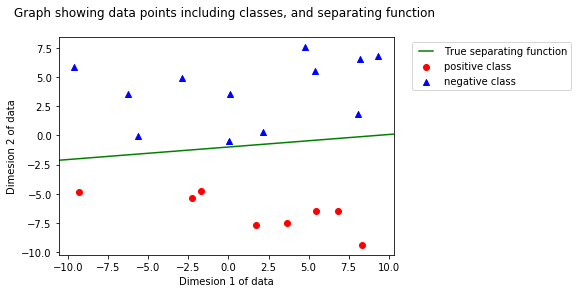

In [42]:
#generate random data         
dataDF, meanMagnitudeOfData  = CreateRandomData(nDataPoints = 20, nDimensions = 2)

# create random separating bounary and return data frame labelled and with the 'true' weights
dataDF, weightsTrue = CreateBoundaryAndLabel(inputDataDF = dataDF, meanMagnitudeOfData = meanMagnitudeOfData)

#title for graph
title = "Graph showing data points including classes, and separating function \n"

#plot data
PlotData(inputDataDF = dataDF, weightsList = [weightsTrue], graphTitle = title)


    

## Problem 1.4 (b)

(b) Run the perceptron algorithm on the dataset. Report the number of updates that the algorithm takes before converging. Plot the examples {(xn,yn)}, the target function f, and the ﬁnal hypothesis g in the same ﬁgure.


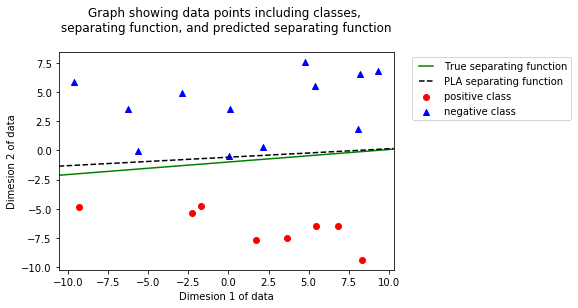

number of updates taken by algorithm = 21 

time taken by PLA algorithm = 0.01562 seconds


In [43]:
#since we are using the data created and labelled from (a) above we do not need to re run the data creation code as 
# the variables persist

#run perceptron learning algorithm
weightsPla, timeToRun, nUpdates = PerceptronLearningAlgorithm(inputDataDF = dataDF,  meanMagnitudeOfData = meanMagnitudeOfData)

# add weights to a list for the plotting function so it can plot both
weights = [weightsTrue, weightsPla]

#title for graph
title = "Graph showing data points including classes, \n separating function, and predicted separating function \n"

#plot data
PlotData(inputDataDF = dataDF, weightsList = weights, graphTitle = title)

#print out other useful information about the running of the algorithm
print("number of updates taken by algorithm = %s \n" %nUpdates)
print("time taken by PLA algorithm = %0.5f seconds" %timeToRun)

## Problem 1.4 (c)

(c) Repeat everything in (b) with another randomly generated dataset of size 20, and compare the result to (b).

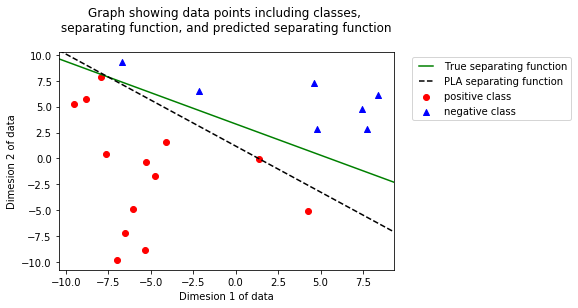

number of updates taken by algorithm = 114 

time taken by PLA algorithm = 0.05696 seconds


In [115]:
Main(nDataPointsMain = 20, nDimensionsMain = 2)

Comparison:

Both (c) and (b) were successful producing a separating line. (c) took more updates and thus more time to converge but overall the algorithm took a similar amount of time. Any differences are likely due to random choice of data points and weights.

## Problem 1.4 (d)

 (d) Repeat everything in (b) with another randomly generated dataset of size 100, and compare the result to (b).

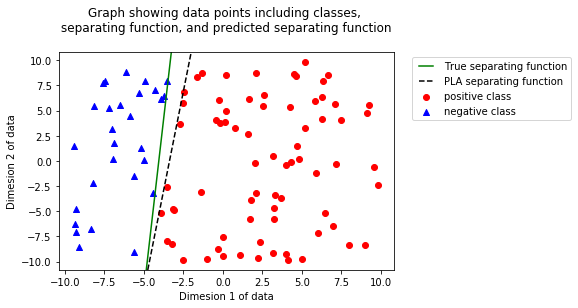

number of updates taken by algorithm = 153 

time taken by PLA algorithm = 0.09938 seconds


In [114]:
Main(nDataPointsMain = 100, nDimensionsMain = 2)

Comparison:

Both (d) and (b) produced successful boundaries with a similar error between the true weights and predicted weights. The running time was about 7 times longer for (d) than (b) given 5 times the number of data points possible evidence that in the same dimension the algorithm scales proportional to the number of data points, although more data will be needed to investigate this relationship.
    

## Problem 1.4 (e)

(e) Repeat everything in (b) with another randomly generated dataset of size 1000, and compare the result to (b). 

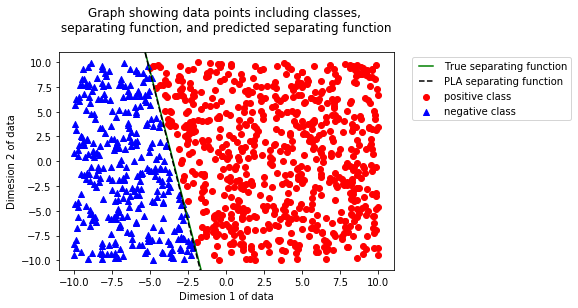

number of updates taken by algorithm = 1243 

time taken by PLA algorithm = 3.14042 seconds


In [106]:
Main(nDataPointsMain = 1000, nDimensionsMain = 2)

Comparison:

Both (e) and (b) produced separating planes, the plane in (e) appears to be a closer approximation to the true separating plane. From the graphs it appears that in (e) the space is more densely filled thus leaving fewer options for the separating plane, thus meaning the plane must be closer to the original. There is approximately a 2,000 times multiplier between the time in (b) and in (e), given the number of data points in (e) is 50 times that of (b) this is evidence that the relationship between running time and number of data points is larger than a proportional relationship.


## Problem 1.4 (f)

(f) Modify the experiment such that xn ∈ R^10 instead of R^2. Run the algorithm on a randomly generated dataset of size 1000. How many updates does the algorithm take to converge?

In [119]:
Main(nDataPointsMain = 1000, nDimensionsMain = 10)

True weights = [50.46075588 -3.03200935 -2.42134684  2.66148601  2.87415004  2.84412558
  1.63035163 -2.77218769 -0.51732094  0.40169747 -1.26801786] 

PLA algorithm weights = [2079.57211888 -129.6917606   -91.10903582  114.5159496   116.82521898
  125.89070814   67.97522458 -108.8949055   -18.56923105   12.89054365
  -48.54507295] 

number of updates taken by algorithm 19476 
time taken by PLA algorithm = 48.32786 seconds


## Problem 1.4 (g)

(g) Summarize your conclusions regarding the accuracy and running time of the algorithm as a function of N (the number of data points) and d (the number of dimensions).

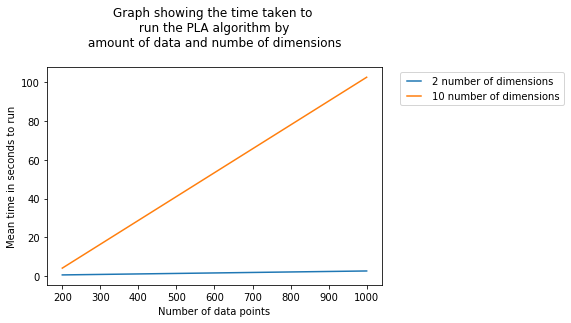

In [117]:
#dictionary to store results
dataDict = {}

# loop though dimensions
for nDimensionsToTest in [2, 10]:
    #storesthe average for each number of data points
    averageStoreList= []
    # loop through data points
    for nDataPointsTest in [200,1000]:
        # stores the time for each test run to average later
        innerTestListTime = []
        # run 4 test to get results
        for nTestRepeats in range(3):
            
            # create data
            dataDF, meanMagnitudeOfData = CreateRandomData(nDataPoints = nDataPointsTest, nDimensions = nDimensionsToTest)
            
            #create separating hyperpleane and label data
            dataDF, weightsTrue = CreateBoundaryAndLabel(inputDataDF = dataDF, meanMagnitudeOfData = meanMagnitudeOfData)
            
            # run PLA algorithm
            weightsPla, timeToRun, nUpdates = PerceptronLearningAlgorithm(inputDataDF = dataDF,
                                                                          meanMagnitudeOfData = meanMagnitudeOfData)
            
            #store time for this run
            innerTestListTime.append(timeToRun)
        
        # calculate average for all runs with dimensionss and data points fixed
        averageStoreList.append([nDataPointsTest, sum(innerTestListTime)/len(innerTestListTime)])
    
      # after each number of data points is finished store the data in the dict    
    dataDict[nDimensionsToTest] = averageStoreList

########################
##### plot data ########
######################## 

# iterate through dict
for key, value in dataDict.items():
    
    #convert values to np array 
    temp = np.array(value)
    #take the number of data items as X
    tempY = temp[:,1]
    
    # take the time taken as Y
    tempX = temp[:,0]
    
    
    
    # plot line, key being the number of dimensions
    plt.plot(tempX,tempY, label = "%i number of dimensions" %key)

# set graph data
ax = plt.gca()   
ax.set_title("Graph showing the time taken to \n run the PLA algorithm by \n amount of data and numbe of dimensions \n")
plt.legend(loc = "upper left", bbox_to_anchor=(1.04, 1), numpoints=4, fontsize=10)
plt.xlabel("Number of data points")
plt.ylabel("Mean time in seconds to run")
plt.show()
 

## Discussion about time complexity of algorithm

As we see from the above tests there is a 5 times multiplier in the number of data points between (c) and (d) (20 data points to 100 data points ), and the time taken in seconds respectively is 0.05696 and 0.09938 this is a 1.74 times multiplier in the time taken, there is a 10 times increase in the number of points between (d) and (e) (100 data points to 1000 data points) and the time taken in seconds respectively was 0.09938 and 3.14042 this is a 31.6 times multiplier in the time taken. Under the assumption this is a linear relationship between number of data points and time taken the problems (c) and (d) would suggest a linear relationship approximate of 

time = 0.34 * (nDataPoints) + 2.94

using this to predict the time value for (e) we would predict around 19 seconds, around 1/3 less than the true number observed.

Now investigating the relationship between time and dimensionality, between (e) and (f) there is a 5 times multiplier in the size of the dimensions, (2 dimensions to 10 dimensions respectively). The time in seconds taken to run the algorithm here went from 3.14042 to 48.32786 this is a 15.4 times multiplier. 

This above discussion has intentionally not been mathematically rigorous, this is because there is not enough data to infer an accurate relationship between dimensions, data points and time. Each experiment was only conducted once and from my experience running this algorithm there can be a lot of variability which I expect is down to the random choice of data points, separating functions, and initial weights used in the algorithm.

In order to get a better understanding I re-ran experiments with 2, 10 dimensions and 200, 1000 data points 3 times for each pair of dimensions, averaged the results. This data can be seen in the graph directly above. The numbers used to generate this graph are 


Dimensions:  2  

nData items: 200
time taken: 0.7264119784037272

nData items : 1000
time taken: 2.7535816033681235


Dimensions:  10

nData items: 200
time taken: 4.219735781351726

nData items: 1000
time taken : 102.42598557472229

Note there is a 5 fold increase between dimensions and number of data points.

as we can see in 2 dimensions with a 5 fold increase in the number of data items there is approximately a 5 fold increase in the time taken

as we can see in 10 dimensions with a 5 fold increase in the number of data items there is approximately a 25 fold increase in the time taken

with 200 data points with a 5 fold increase in the number of dimensions there is approximately a 5 fold increase in the time taken

with 1000 data points with a 5 fold increase in the number of dimensions there is a approximately a 50 fold increase in the time taken

From this very small sample size it seems likely that the true relationship between time T, data points P, and dimensions D is something of the order T = D * P

Although the evidence from (e) above shows a large difference between an increase of data points significantly larger than proportional. Taking this also into account it is possible there is some polynomial grown with respect to the number of data points giving a relationship in the order of T = D * (P^2)

More time to study the algorithm would be needed to investigate further.





It should be noted however that it is possible the number of data points is not necessarily the reason for the data seen above, it's possible the sparseness of the data is contributing to the relationship seen above. All the data above is by default between -10 and 10, it is possible that for any given number of data points if the bounds are larger the algorithm may be quicker. This has not been tested in this experiment.

In addition to the above experimentation with the algorithm an interesting metric to investigate would be how the size of the misclassification area changes with the number of data points and the number of dimensions. I believe this could be calculated with the help of the heaviside function as follows:

integral (abs(H(a)-H(b)) / integral (1)  both integrals over the bounds of the data

where H is the heaviside function, and a, b are the linear functions whose coefficients are the weights of the separating function.

The above would give the percentage of area/volume misclassified by the predicted decision boundary with respect to the total area we could expect to find a data point. I believe this would show the PLA algorithm would show increasingly good approximations with respect to the number of data items. The reason for this is the denser the points are packed in space the fewer the options for the weights of the separating function.


## Appendix 1 - Testing

dataPoint =  [1 1 4]
tempLabel =  1.0
tempDotProd =  -32
nUpdates =  1
new weights =  [-35.  13.   2.]
-------------------------------
dataPoint =  [1 1 4]
tempLabel =  1.0
tempDotProd =  -14.0
nUpdates =  2
new weights =  [-34.  14.   6.]
-------------------------------
dataPoint =  [ 1  5 30]
tempLabel =  -1.0
tempDotProd =  216.0
nUpdates =  3
new weights =  [-35.   9. -24.]
-------------------------------
dataPoint =  [1 1 4]
tempLabel =  1.0
tempDotProd =  -122.0
nUpdates =  4
new weights =  [-34.  10. -20.]
-------------------------------
dataPoint =  [1 1 4]
tempLabel =  1.0
tempDotProd =  -104.0
nUpdates =  5
new weights =  [-33.  11. -16.]
-------------------------------
dataPoint =  [1 1 4]
tempLabel =  1.0
tempDotProd =  -86.0
nUpdates =  6
new weights =  [-32.  12. -12.]
-------------------------------
dataPoint =  [1 1 4]
tempLabel =  1.0
tempDotProd =  -68.0
nUpdates =  7
new weights =  [-31.  13.  -8.]
-------------------------------
dataPoint =  [1 1 4]
tempLabel =  1.0

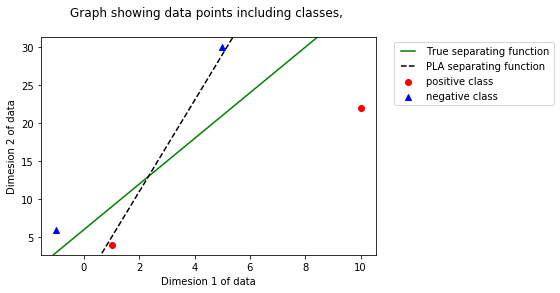

True weights = [ 6  3 -1] 

PLA algorithm weights = [-4. 24. -4.] 

number of updates taken by algorithm 42 
time taken by PLA algorithm = 0.06265 seconds


In [60]:
# Test run, see accompanying excel document

# using known data so define data, this means the the functionality to create data is not needed
dataDF = pd.DataFrame([[1,1,4],[1,10,22],[1,-1,6],[1,5,30]], columns = ['dim_0','dim_1','dim_2'])

meanMagnitude = np.sqrt(np.square(dataDF)).sum(axis=1).mean()

#hese weights were used to separate the data
knownWeights = np.array([6,3,-1])

# these were the starting weights used in the excel document
startWeights = np.array([-36,12,-2])

# label data
dataDF, _ = CreateBoundaryAndLabel(dataDF, weights = knownWeights, meanMagnitudeOfData = meanMagnitude, seed = 200)

#run PLA with debug as true to print out the interim weights
weightsPla, timeToRun, nUpdates = PerceptronLearningAlgorithm(dataDF, weights = startWeights,
                                                              meanMagnitudeOfData = meanMagnitude, 
                                                              debug=True, seed = 300)

title = "Graph showing data points including classes, \n"
"separating function, and predicted separating function \n for test data"

weights = [knownWeights, weightsPla]

PlotData(inputDataDF = dataDF, weightsList = weights, graphTitle = title)

print("True weights = %s \n" %knownWeights)
print("PLA algorithm weights = %s \n" %weightsPla)
print("number of updates taken by algorithm %s "% nUpdates)
print("time taken by PLA algorithm = %0.5f seconds" %timeToRun)



By checking the data above with the data contained within the accompanying excel document it can be seen that both approaches provide the same data. The functions which run this algorithm in excel can be investigated in the formula bar to show both approaches are instances of the same algorithm. Although the above test does not prove the code is correct, it provides assurance that the code is likely to be correct if exactly the same results have been achieved via two entirely unconnected media. 